In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.data.path.append(r'C:\Users\suyas\AppData\Roaming\nltk_data\tokenizers\punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")


In [2]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [41]:
# Load the dataset
# Download 'Reviews.csv' file from Kaggle's Amazon product Reviews dataset and place it in your working directory.
df = pd.read_csv('Reviews.csv')

In [42]:
# Basic data exploration
print(df.shape)
print(df.columns)
print(df.head())

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0  

In [43]:
# Keeping only essential columns
df = df[['Text', 'Score']]
df = df[df['Score'] != 3]  # Removing neutral reviews (3-star reviews)
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)  # Positive = 1, Negative = 0

print(df.head())

                                                Text  Score  Sentiment
0  I have bought several of the Vitality canned d...      5          1
1  Product arrived labeled as Jumbo Salted Peanut...      1          0
2  This is a confection that has been around a fe...      4          1
3  If you are looking for the secret ingredient i...      2          0
4  Great taffy at a great price.  There was a wid...      5          1


In [44]:
# Data Preprocessing
def preprocess_text(text):
    """
    Preprocess the input text by converting to lowercase, 
    removing punctuation, numbers, and stopwords.
    """
    # Convert text to lowercase
    text = text.lower()

    # Handle negations
    text = re.sub(r"not\s+(\w+)", r"not_\1", text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    return ' '.join(filtered_text)

In [45]:
# Apply text preprocessing to the dataset
df['cleaned_text'] = df['Text'].apply(preprocess_text)

In [46]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()

# Labels
y = df['Sentiment']

In [47]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Model Training using Logistic Regression
model = LogisticRegression(max_iter=1000, solver='saga', tol=1e-3, n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga', tol=0.001)

In [49]:
import joblib

joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


              precision    recall  f1-score   support

           0       0.86      0.71      0.78     16379
           1       0.95      0.98      0.96     88784

    accuracy                           0.94    105163
   macro avg       0.90      0.85      0.87    105163
weighted avg       0.93      0.94      0.93    105163



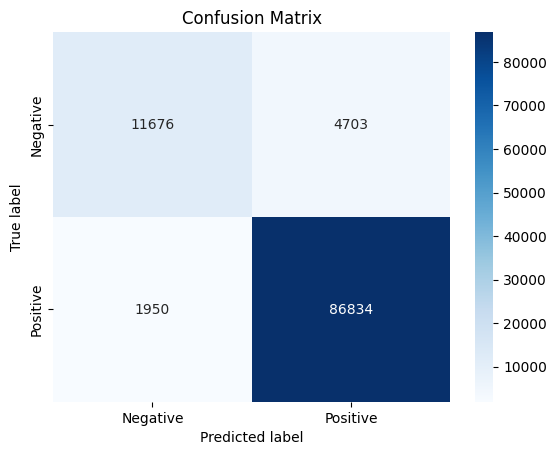

In [50]:
# Model Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

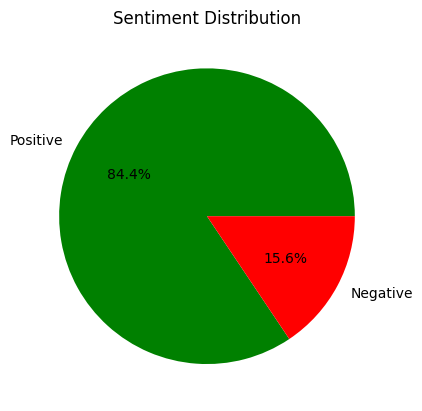

In [51]:
# Sentiment Distribution Pie Chart
sentiment_count = df['Sentiment'].value_counts()
sentiment_count.plot(kind='pie', labels=['Positive','Negative'], autopct='%1.1f%%', colors=['green','red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

In [52]:
# Function to test the model with custom input
def predict_sentiment(review):
    """
    Predict the sentiment of a given review (positive or negative).
    """
    # Preprocess the input review
    review_cleaned = preprocess_text(review)
    
    # Transform the review using the trained TF-IDF vectorizer
    review_tfidf = tfidf.transform([review_cleaned]).toarray()
    
    # Predict the sentiment
    sentiment = model.predict(review_tfidf)
    
    return 'Positive' if sentiment == 1 else 'Negative'

In [53]:
# Example test
example_review = "This product is amazing and works perfectly!"
print(predict_sentiment(example_review))

Positive
